In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loading the Data

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
PROJECT_PATH = '/content/drive/My Drive/Datasets/ML Project'
FIGURES_PATH = f'{PROJECT_PATH}/figures/preprocessing'
def get_figure_path(name: str):
  return f'{FIGURES_PATH}/{name}.png'
DATASETS_PATH = f'{PROJECT_PATH}/data/recommended'
TRAINING_PATH = f'{DATASETS_PATH}/training/training.csv'
TESTING_PATH = f'{DATASETS_PATH}/test/test.csv'
INDEX_COL = 'pkSeqID'
COLUMNS_ORDERED = [
    'min', 'max', 'mean', 'stddev',
    'saddr', 'sport', 'daddr', 'dport',
    'srate', 'drate',
    'N_IN_Conn_P_SrcIP', 'N_IN_Conn_P_DstIP',
    'state_number', 'proto',
    'seq',
    'attack', 'category', 'subcategory'
]

In [4]:
training = pd.read_csv(TRAINING_PATH, index_col=INDEX_COL)[COLUMNS_ORDERED]
training.head()

,min,max,mean,stddev,saddr,sport,daddr,dport,srate,drate,N_IN_Conn_P_SrcIP,N_IN_Conn_P_DstIP,state_number,proto,seq,attack,category,subcategory
pkSeqID,,,,,,,,,,,,,,,,,,
3142762,0.000000,4.031619,2.687519,1.900363,192.168.100.150,6551,192.168.100.3,80,0.494549,0.0,100,100,4,udp,251984,1,DDoS,UDP
2432264,3.856930,4.012924,3.934927,0.078003,192.168.100.150,5532,192.168.100.3,80,0.256493,0.0,38,100,3,tcp,256724,1,DDoS,TCP
1976315,2.974100,3.609205,3.341429,0.268666,192.168.100.147,27165,192.168.100.3,80,0.294880,0.0,100,100,3,tcp,62921,1,DDoS,TCP
1240757,0.000000,4.942302,3.222832,1.823185,192.168.100.150,48719,192.168.100.3,80,0.461435,0.0,63,63,4,udp,99168,1,DoS,UDP
3257991,2.979995,4.994452,3.983222,0.822418,192.168.100.147,22461,192.168.100.3,80,1.002999,0.0,100,100,4,udp,105063,1,DDoS,UDP


In [5]:
testing = pd.read_csv(TESTING_PATH, index_col=INDEX_COL)[COLUMNS_ORDERED]

In [6]:
def process_categories(cat):
  if str(cat).lower().startswith('theft'):
    return 'Theft'
  if str(cat).lower().startswith('normal'):
    return 'Normal'
  if cat == 'DoS HTTP':
    return 'DoS TCP'
  if cat == 'DDoS HTTP':
    return 'DDoS TCP'
  return cat


In [7]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

cat_encoder_hot = OneHotEncoder()
cat_encoder_label = LabelEncoder()

In [8]:
X_train = training.drop(['attack' ,'category', 'subcategory'], axis=1)
y_train_cat = pd.DataFrame({'category': (training['category'] + ' ' + training['subcategory']).map(process_categories)})
y_train_hot = cat_encoder_hot.fit_transform(y_train_cat)
y_train_label = cat_encoder_label.fit_transform(y_train_cat['category'])

In [9]:
X_test = testing.drop(['attack', 'category', 'subcategory'], axis=1)
y_test_cat = pd.DataFrame({'category': (testing['category'] + ' ' + testing['subcategory']).map(process_categories)})
y_test_hot = cat_encoder_hot.transform(y_test_cat)
y_test_label = cat_encoder_label.transform(y_test_cat['category'])

In [10]:
X_train.head()

,min,max,mean,stddev,saddr,sport,daddr,dport,srate,drate,N_IN_Conn_P_SrcIP,N_IN_Conn_P_DstIP,state_number,proto,seq
pkSeqID,,,,,,,,,,,,,,,
3142762,0.000000,4.031619,2.687519,1.900363,192.168.100.150,6551,192.168.100.3,80,0.494549,0.0,100,100,4,udp,251984
2432264,3.856930,4.012924,3.934927,0.078003,192.168.100.150,5532,192.168.100.3,80,0.256493,0.0,38,100,3,tcp,256724
1976315,2.974100,3.609205,3.341429,0.268666,192.168.100.147,27165,192.168.100.3,80,0.294880,0.0,100,100,3,tcp,62921
1240757,0.000000,4.942302,3.222832,1.823185,192.168.100.150,48719,192.168.100.3,80,0.461435,0.0,63,63,4,udp,99168
3257991,2.979995,4.994452,3.983222,0.822418,192.168.100.147,22461,192.168.100.3,80,1.002999,0.0,100,100,4,udp,105063


In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate, train_test_split

In [12]:
def process_port(p):
  return int(p, 16) if str(p).startswith('0x') else int(p)

def process_ports(ports: pd.DataFrame):
  return ports.map(process_port)


In [13]:
DEFAULT_RATE_SHIFT = 1.1

In [14]:
def shift_and_log(data, shift=DEFAULT_RATE_SHIFT): # 1.1 So that the output has no zero values, and a small change is not that significant
  return np.log10(data + shift)

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin

srate_idx, drate_idx = [list(training.columns).index('srate'), list(training.columns).index('drate')]
class CombinedFeatureAdder(BaseEstimator, TransformerMixin):
  def __init__(self, normalize=True) -> None:
    super().__init__()
    self.normalize = normalize

  def fit(self, X, y=None):
    return self

  def transform(self, X: pd.DataFrame, y=None):
    srate_to_drate = np.log10(X.loc[:, 'srate'] + DEFAULT_RATE_SHIFT) / np.log10(X.loc[:, 'drate'] + DEFAULT_RATE_SHIFT)
    if self.normalize:
      return X.assign(srate_to_drate=np.log1p(srate_to_drate))
    else:
      return X.assign(srate_to_drate=srate_to_drate)

In [16]:
TO_DROP = ['saddr', 'daddr', 'seq']

data_cleaner = ColumnTransformer([
  ('drop', 'drop', TO_DROP),
  ('encode', OneHotEncoder(), ['proto']),
  ('port', FunctionTransformer(func=process_ports), ['sport', 'dport']),
  ('rate', FunctionTransformer(func=shift_and_log), ['srate', 'drate']),
], remainder='passthrough')

data_prep = Pipeline([
    ('augment', CombinedFeatureAdder()),
    ('clean', data_cleaner),
    ('std', StandardScaler()),
])

X_train_cleaned = data_prep.fit_transform(X_train)

In [17]:
X_train_cleaned.shape

(2934817, 17)

In [18]:
X_train_eval, _, y_train_eval_label, _, y_train_eval_hot, _, indices, _ = train_test_split(
    X_train_cleaned,
    y_train_label,
    y_train_hot,
    [i for i in range(len(y_train_label))],
    train_size=0.1,
    stratify=y_train_label,
    random_state=42
)

In [19]:
from cuml.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score

def score_dbscan(eps, min_samples, X):
    print(f'Processing eps={eps}, min_samples={min_samples}...')
    model = DBSCAN(eps=eps, min_samples=min_samples)
    predictions = model.fit_predict(X)
    print('Model fitted.')
    out = {
        'eps': eps,
        'min_samples': min_samples,
        'davies': davies_bouldin_score(X_train_eval, predictions),
        'predictions': predictions,
        'classes': len(np.unique(predictions)),
        'outliers': sum(predictions == -1),
    }
    print('Done processing.')
    return out

In [20]:
%%script true
eps = [0.5, 1]
min_samples = [5, 50]

scores = []

for v1 in eps:
  for v2 in min_samples:
    scores.append(score_dbscan(v1, v2, X_train_eval))

pd.DataFrame(scores).drop('predictions', axis=1)

In [21]:
%%script true
test_1_scores = scores
pd.DataFrame(test_1_scores).drop('predictions', axis=1)

In [22]:
%%script true
eps = [1, 5, 10, 20, 30, 50, 100]
min_samples = 50
scores = []

for e in eps:
  scores.append(score_dbscan(e, min_samples, X_train_eval))


In [23]:
%%script true
test_2_scores = scores
pd.DataFrame(test_2_scores).drop('predictions', axis=1)

In [24]:
%%script true
eps = [i for i in range(21, 30)]
min_samples = 50
scores = []

for e in eps:
  scores.append(score_dbscan(e, min_samples, X_train_eval))

In [25]:
%%script true
test_3_scores = scores
pd.DataFrame(test_3_scores).drop('predictions', axis=1)

It seems the optimum epsilon value is 27

In [26]:
%%script true
eps = 27
min_samples = [5, 10, 20, 50, 100, 200, 300]
scores = []

for m in min_samples:
  scores.append(score_dbscan(eps, m, X_train_eval))

In [27]:
%%script true
test_4_scores = scores
pd.DataFrame(test_4_scores).drop('predictions', axis=1)

This clearly shows that lower values of min_samples improve the model significantly, need to try > 5

In [28]:
eps = 27
min_samples = [i for i in range(1, 5)]
scores = []

for m in min_samples:
  scores.append(score_dbscan(eps, m, X_train_eval))

Processing eps=27, min_samples=1...
[2025-12-07 06:43:06.428] [CUML] [info] Batch size limited by the chosen integer type (4 bytes). 8600 -> 7317. Using the larger integer type might result in better performance
Model fitted.
Done processing.
Processing eps=27, min_samples=2...
[2025-12-07 06:45:13.164] [CUML] [info] Batch size limited by the chosen integer type (4 bytes). 8600 -> 7317. Using the larger integer type might result in better performance
Model fitted.
Done processing.
Processing eps=27, min_samples=3...
[2025-12-07 06:47:19.168] [CUML] [info] Batch size limited by the chosen integer type (4 bytes). 8600 -> 7317. Using the larger integer type might result in better performance
Model fitted.
Done processing.
Processing eps=27, min_samples=4...
[2025-12-07 06:49:25.190] [CUML] [info] Batch size limited by the chosen integer type (4 bytes). 8600 -> 7317. Using the larger integer type might result in better performance
Model fitted.
Done processing.


In [29]:
test_5_scores = scores
pd.DataFrame(test_5_scores).drop('predictions', axis=1)

,eps,min_samples,davies,classes,outliers
0,27,1,0.033069,3,0
1,27,2,0.033069,3,0
2,27,3,0.033069,3,2
3,27,4,0.033069,3,2


In [34]:
eps = [(27 + 0.1 * i) for i in range(1, 10)]
min_samples = 10
scores = []

for e in eps:
  scores.append(score_dbscan(e, min_samples, X_train_eval))

Processing eps=27.1, min_samples=10...
[2025-12-07 07:01:43.154] [CUML] [info] Batch size limited by the chosen integer type (4 bytes). 8600 -> 7317. Using the larger integer type might result in better performance
Model fitted.
Done processing.
Processing eps=27.2, min_samples=10...
[2025-12-07 07:03:49.033] [CUML] [info] Batch size limited by the chosen integer type (4 bytes). 8600 -> 7317. Using the larger integer type might result in better performance
Model fitted.
Done processing.
Processing eps=27.3, min_samples=10...
[2025-12-07 07:05:54.753] [CUML] [info] Batch size limited by the chosen integer type (4 bytes). 8600 -> 7317. Using the larger integer type might result in better performance
Model fitted.
Done processing.
Processing eps=27.4, min_samples=10...
[2025-12-07 07:08:00.450] [CUML] [info] Batch size limited by the chosen integer type (4 bytes). 8600 -> 7317. Using the larger integer type might result in better performance
Model fitted.
Done processing.
Processing eps=2

In [35]:
test_6_scores = scores
pd.DataFrame(test_6_scores).drop('predictions', axis=1)

,eps,min_samples,davies,classes,outliers
0,27.1,10,0.033069,3,2
1,27.2,10,0.033069,3,2
2,27.3,10,0.033069,3,2
3,27.4,10,0.033069,3,2
4,27.5,10,0.033069,3,2
5,27.6,10,0.033069,3,2
6,27.7,10,0.033069,3,2
7,27.8,10,0.033069,3,2
8,27.9,10,0.033069,3,2


In [30]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.8)
reduced = pca.fit_transform(X_train_cleaned)

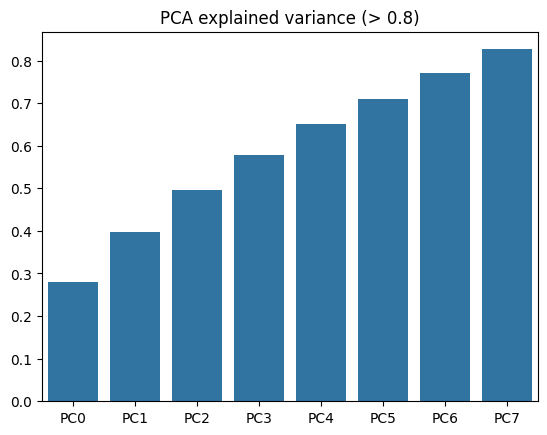

In [31]:
sns.barplot(x=[f'PC{i}' for i in range(len(pca.components_))], y=np.cumsum(pca.explained_variance_ratio_))
title = 'PCA explained variance (> 0.8)'
plt.title(title)
plt.savefig(get_figure_path(title))

In [32]:
pca_2 = PCA(n_components=2)
reduced_2_complete = pca_2.fit_transform(X_train_cleaned)
reduced_2 = pca_2.fit_transform(X_train_eval)

In [33]:
sns.scatterplot(x=reduced_2_complete[:, 0], y=reduced_2_complete[:, 1], hue=y_train_label)
title = 'Scatter plot of data per category with 2 principle components'
plt.xlabel('PC0')
plt.ylabel('PC1')
plt.title(title)
plt.savefig(get_figure_path(title))

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7940931f9e40> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7940931f98a0> (for post_execute):


KeyboardInterrupt: 

# TODO: Test with 8 features form PCA

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from cuml.ensemble import RandomForestClassifier
from cuml.linear_model import LogisticRegression
from cuml.neighbors import KNeighborsClassifier

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
}

no_pca_results = []
pca_results = []

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model_name, model in models.items():
    y_target = y_train_eval_label

    X_no_pca = X_train_eval
    X_pca = reduced_2

    print(f'Processing model {model_name} no PCA...')
    cv_scores_no_pca = cross_val_score(model, X_no_pca, y_target, cv=cv, scoring='accuracy', n_jobs=-1)
    print(f'Processing model {model_name} with PCA...')
    cv_scores_pca = cross_val_score(model, X_pca, y_target, cv=cv, scoring='accuracy', n_jobs=-1)

    no_pca_results.append({
        'model': model_name,
        'cv_mean': np.mean(cv_scores_no_pca),
        'cv_std': np.std(cv_scores_no_pca),
        'scores': cv_scores_no_pca
    })

    pca_results.append({
        'model': model_name,
        'cv_mean': np.mean(cv_scores_pca),
        'cv_std': np.std(cv_scores_pca),
        'scores': cv_scores_pca
    })
    print(f'Processing model done.')

no_pca_df = pd.DataFrame(no_pca_results)
pca_df = pd.DataFrame(pca_results)

In [ ]:
results_df = pd.DataFrame({
    'model': no_pca_df['model'],
    'no_pca_mean': no_pca_df['cv_mean'],
    'no_pca_std': no_pca_df['cv_std'],
    'pca_mean': pca_df['cv_mean'],
    'pca_std': pca_df['cv_std'],
    'difference': pca_df['cv_mean'] - no_pca_df['cv_mean']
})

print("\nComparison:")
results_df